In [106]:
# import some libraries
%matplotlib inline  
import numpy as np
import tensorflow as tf
import tensorflow.contrib.learn as skflow
import sklearn
import matplotlib.pyplot as plt

In [84]:
# Load a dataset

#data = 'iris'
#data = 'digits'
#data = 'mnist'
data = 'hastie' # synthetic dataset, hard enough to ilustrate differences clearly

if data == 'iris':
    iris = sklearn.datasets.load_iris()
    X = iris.data
    y = iris.target
elif digits == 'digits':
    digits = sklearn.datasets.load_digits()
    # This is not MNIST, but a smaller dataset of 1797 instances of
    # 8x8 images with integer pixels in the range 0..16.
    #http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits
    N = digits.images.shape[0]
    X = np.reshape(digits.images, [N, 8*8])
    y = digits.target
elif data == 'mnist':
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)
    # mnist.{train, validation, test}.{images, labels}
    # The images are N * 784 in size
    # Train: 55k, valid: 5k, test: 10k
    # For speed, we just use a small subset of 1000 examples.
    indices = np.random.choice(55000, 5000)
    X = mnist.train.images[indices,:]
    y = mnist.train.labels[indices]
elif data == 'hastie':
    sklearn.datasets.make_hastie_10_2(n_samples=1000, random_state=42)
    X, y = sklearn.datasets.make_hastie_10_2(n_samples=1000, random_state=42)
    # switch from -1,1 to 0,1
    ndx = (y == -1)
    y[ndx] = 0
else:
    raise ValueError('unknown dataset {}'.format(data))
    
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)
n_classes = len(np.unique(y))
print 'Ntrain={}, Ntest={}, Nfeatures={}, Nclasses={}'.format(
        X_train.shape[0], X_test.shape[0], X_train.shape[1], n_classes)


Ntrain=800, Ntest=200, Nfeatures=10, Nclasses=2


In [85]:
# Fit logistic regression model using standard sklearn (batch training using BFGS)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e5) # turn off regularization
model.fit(X_train, y_train)

# Function to compute train and test error.
def eval(model):
    acc = sklearn.metrics.accuracy_score(y_train, model.predict(X_train))
    print 'training accuracy {}'.format(acc)
    acc = sklearn.metrics.accuracy_score(y_test, model.predict(X_test))
    print 'testing accuracy {}'.format(acc)

# Let's evaluate the model.
eval(model)

training accuracy 0.57
testing accuracy 0.575


In [87]:
# Now try using skflow (online training using SGD)
from tensorflow.python.framework import random_seed
seed = 42
model = skflow.TensorFlowLinearClassifier(n_classes=n_classes)
random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)

Step #100, epoch #4, avg. train loss: 0.70135
Step #200, epoch #8, avg. train loss: 0.69714
training accuracy 0.5775
testing accuracy 0.57


In [89]:
# Let's examine the resulting parameters
print 'weights {}, bias {}'.format(model.weights_, model.bias_)

weights [[ 0.00347729 -0.00347726]
 [-0.00836525  0.00836527]
 [-0.01994835  0.01994838]
 [ 0.01383986 -0.01383988]
 [-0.01960176  0.01960175]
 [ 0.00474693 -0.00474694]
 [-0.02187933  0.02187933]
 [-0.03824039  0.03824043]
 [ 0.00658222 -0.00658221]
 [-0.01298285  0.01298286]], bias [ 0.0557811  -0.05578107]


In [122]:
# Now try fitting an MLP.
# Training and testing accuracy is higher than with linear model.
# But testing accuracy is lower than training accuracy, indicating overfitting.
hidden_units = [20, 20, 20]
model = skflow.TensorFlowDNNClassifier(hidden_units=hidden_units, n_classes=n_classes)
random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)    

Step #100, epoch #7, avg. train loss: 0.50513
Step #200, epoch #15, avg. train loss: 0.24947
training accuracy 0.975550122249
testing accuracy 0.81


In [110]:
# Print the size of each layer (can only do this after model fitting, since variables need to be initialized)
n_layers = len(model.hidden_units)+1
for l in range(n_layers):
    print 'layer {} weights {}, bias {}'.format(l, model.weights_[l].shape, model.bias_[l].shape)


layer 0 weights (10, 20), bias (20,)
layer 1 weights (20, 20), bias (20,)
layer 2 weights (20, 20), bias (20,)
layer 3 weights (20, 2), bias (2,)


In [135]:
# Log some data while training, then display it in tensorboard
model.fit(X_train, y_train, logdir="/tmp/data/my_model")

# Use this command to visualize results
#tensorboard --logdir=/tmp/data/my_model

Step #100, epoch #7, avg. train loss: 0.67869
Step #200, epoch #15, avg. train loss: 0.64630


TensorFlowEstimator(batch_size=32, class_weight=None, clip_gradients=5.0,
          config=None, continue_training=False, learning_rate=0.1,
          model_fn=<function my_model at 0x121fdab90>, n_classes=2,
          optimizer='Adagrad', steps=200, verbose=1)

In [140]:
# Example of how to fit a "custom" model.
# We'll use an MLP with dropout, to reduce overfitting. 
# With dropout probability of 0.5, we underfit significantly.
def my_model(X, y, dropout=0.5):
    layers = skflow.ops.dnn(X, hidden_units, dropout=dropout)
    return skflow.models.logistic_regression(layers, y)

model = skflow.TensorFlowEstimator(model_fn=my_model, n_classes=n_classes)
random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)

Step #100, epoch #7, avg. train loss: 0.67869
Step #200, epoch #15, avg. train loss: 0.64630
training accuracy 0.545232273839
testing accuracy 0.49


In [134]:
# Example of how to access the parameters of a custom model.
weights = model.get_tensor_value('logistic_regression/weights:0')
bias = model.get_tensor_value('logistic_regression/bias:0')
print 'output layer, weights {}, bias {}'.format(weights.shape, bias.shape)

for l in range(n_layers-1):
    # By looking at tensorflow/contrib/learn/python/learn/ops/dnn_ops.py,
    # and tensorflow/python/ops/rnn_cell.py, we can figure out the names:
    weights = model.get_tensor_value('dnn/layer{}/Linear/Matrix:0'.format(l))
    bias = model.get_tensor_value('dnn/layer{}/Linear/Bias:0'.format(l))
    print 'layer {}, weights {}, bias {}'.format(l, weights.shape, bias.shape)

output layer, weights (20, 2), bias (2,)
layer 0, weights (10, 20), bias (20,)
layer 1, weights (20, 20), bias (20,)
layer 2, weights (20, 20), bias (20,)


In [39]:
# Let's use grid search (plus cross validation) to estimate the "optimal" degree of dropout.
from sklearn.grid_search import GridSearchCV
hyper_params = [{'dropout': [0.1, 0.5, 0.9]}]
def make_model():
    model = skflow.TensorFlowEstimator(model_fn=my_model, n_classes=n_classes)
clf = GridSearchCV(make_model(), hyper_params, cv=5, scoring=metrics.accuracy_score)

# How can we do this??

In [116]:
# Let's use early stopping as an alternative form of regularization.
X_train, X_val, y_train, y_val = sklearn.cross_validation.train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=42)
val_monitor = skflow.monitors.ValidationMonitor(X_val, y_val,
                                                print_steps=100,
                                                early_stopping_rounds=200,
                                                n_classes=n_classes)
model = skflow.TensorFlowDNNClassifier(hidden_units=hidden_units, n_classes=n_classes, steps=1000)
random_seed.set_random_seed(seed)
model.fit(X_train, y_train, val_monitor)
eval(model)

Step #100, epoch #7, avg. train loss: 0.50513, avg. val loss: 0.58590
Step #200, epoch #15, avg. train loss: 0.24947, avg. val loss: 0.48592
Step #300, epoch #23, avg. train loss: 0.11907, avg. val loss: 0.48816
Step #400, epoch #30, avg. train loss: 0.04776, avg. val loss: 0.54411
training accuracy 1.0
testing accuracy 0.805


Stopping. Best step:
 step 214 with loss 0.404317826033


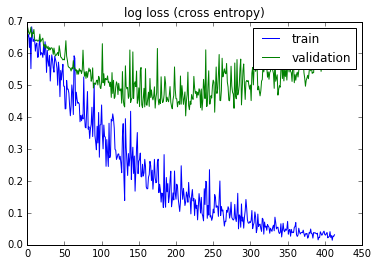

In [117]:
# Let's plot the training and validation loss
plt.figure
plt.plot(val_monitor.all_train_loss_buffer)
plt.plot(val_monitor.all_val_loss_buffer)
#plt.show()
plt.legend(['train', 'validation'])
plt.title('log loss (cross entropy)')

In [118]:
# Example of how to tweak the optimizer (here, by changing learning rate).
def exp_decay(global_step):
    return tf.train.exponential_decay(
        learning_rate=0.1, global_step=global_step,
        decay_steps=100, decay_rate=0.001)

model = skflow.TensorFlowDNNClassifier(hidden_units=hidden_units,
                                            n_classes=n_classes, steps=1000,
                                            optimizer="Adagrad",
                                            learning_rate=exp_decay)

random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)

Step #100, epoch #7, avg. train loss: 0.60915
Step #200, epoch #15, avg. train loss: 0.60123
Step #300, epoch #23, avg. train loss: 0.59988
Step #400, epoch #30, avg. train loss: 0.60095
Step #500, epoch #38, avg. train loss: 0.60090
Step #600, epoch #46, avg. train loss: 0.60122
Step #700, epoch #53, avg. train loss: 0.60035
Step #800, epoch #61, avg. train loss: 0.60067
Step #900, epoch #69, avg. train loss: 0.60084
Step #1000, epoch #76, avg. train loss: 0.60070
training accuracy 0.735941320293
testing accuracy 0.68


In [139]:
# Example of how to save and load a model.
import shutil

model = skflow.TensorFlowDNNClassifier(hidden_units=hidden_units, n_classes=n_classes)
random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)
     
# Clean checkpoint folder if exists
folder = '/tmp/skflow_examples/model'
try:
    shutil.rmtree(folder)
except OSError:
    pass

# Save model, parameters and learned variables.
model.save(folder)
model = None

## Restore everything
new_model = skflow.TensorFlowEstimator.restore(folder)
eval(new_model)

Step #100, epoch #7, avg. train loss: 0.50513
Step #200, epoch #15, avg. train loss: 0.24947
training accuracy 0.975550122249
testing accuracy 0.81
training accuracy 0.975550122249
testing accuracy 0.81


In [123]:
# Example of how to chain together a preprocessor and skflow model.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
scaler = StandardScaler()  # Standardizing the data can often help SGD.

DNNclassifier = skflow.TensorFlowDNNClassifier(hidden_units=hidden_units, n_classes=n_classes)

model = Pipeline([('scaler', scaler), ('DNNclassifier', DNNclassifier)])
random_seed.set_random_seed(seed)
model.fit(X_train, y_train)
eval(model)

Step #100, epoch #7, avg. train loss: 0.50420
Step #200, epoch #15, avg. train loss: 0.24613
training accuracy 0.982885085575
testing accuracy 0.805
